# Noa Tobias: 326335064 
# Nadav Banay:326277910

## Importing libraries, stopwords, and setting constants:

In [59]:
import numpy as np
import re
import string
import tqdm
import matplotlib.pyplot as plt
import nltk
import io
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
SEED = 6
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
EPOCH=8
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nadav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Preprocessing  the Data:

In [39]:
path_to_file = 'contents/reviews_data.txt'

In [40]:
#filtering empty lines
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))
#lowercasing and removes punctation:
text_ds = text_ds.map(lambda x: tf.strings.regex_replace(tf.strings.lower(x), '[%s]' % re.escape(string.punctuation), ''))

### Creating vocab and replcaing context/rare words:

In [41]:
def create_vocab(text_ds):
    vocab = {}
    for line in text_ds:
        for word in line.numpy().decode().split():
            if word in vocab:
                vocab[word] += 1
            else:
                vocab[word] = 1
    return vocab

In [67]:
def filtering(minimal_frq, text_ds):
    v = create_vocab(text_ds)
    #replacing rare words:
    infrequent_words = set(k for k, v in v.items() if v < minimal_frq)
    stop_words = set(stopwords.words('english'))

    
    # Split the patterns into batches
    infrequent_batches = [list(infrequent_words)[i:i+BATCH_SIZE] for i in range(0, len(infrequent_words), BATCH_SIZE)]
    stopword_batches = [list(stop_words)[i:i+BATCH_SIZE] for i in range(0, len(stop_words), BATCH_SIZE)]
    # Apply the replacing the unwanted words
    for infrequent_words_batch in infrequent_batches:
        pattern_infq = r'\b(' + '|'.join(map(re.escape, infrequent_words_batch)) + r')\b'
        text_ds = text_ds.map(lambda x: tf.strings.regex_replace(x, pattern_infq, 'rareword'))
    for stop_words_batch in stopword_batches:
        pattern_stop = r'\b(' + '|'.join(map(re.escape, stop_words_batch)) + r')\b'
        text_ds = text_ds.map(lambda x: tf.strings.regex_replace(x, pattern_stop, 'stopword'))

        
    #updating my vocab:
    v = create_vocab(text_ds)
    v_size = len(v)
    return text_ds, v_size

### Skipgramming:

Generates skip-gram pairs with negative sampling for a list of sequences
(int-encoded sentences) based on window size, number of negative samples
and vocabulary size.

In [68]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    targets, contexts, labels = [], [], []
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in the dataset.
    for sequence in tqdm.tqdm(sequences):
        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(sequence,vocabulary_size=vocab_size,sampling_table=sampling_table,window_size=window_size,negative_samples=0)
   
        # creating training examples with a positive context word and negative samples, out of the positive skipgrams.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(true_classes=context_class,num_true=1,num_sampled=num_ns,unique=True,range_max=vocab_size,seed=seed,name="negative_sampling")

            #append context and label vectors (for one target word)
            targets.append(target_word)
            contexts.append(tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)) #context_words
            labels.append(tf.constant([1] + [0]*num_ns, dtype="int64"))

    return targets, contexts, labels

##### vectorizing:

In [69]:
def create_txt_vec_ds(sequence_length, ds, vocab_size):
    vectorize_layer = layers.TextVectorization(max_tokens=vocab_size,output_mode='int',output_sequence_length=sequence_length)
    vectorize_layer.adapt(ds.batch(BATCH_SIZE))
    inverse_vocab = vectorize_layer.get_vocabulary()
    return text_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE).map(vectorize_layer).unbatch(), vectorize_layer, inverse_vocab

##### creating targets, contexts, labels(+ or - skipgrams):

In [70]:
def create_tar_cont_lab(text_vector_ds, window_size, num_ns, vocab_size):
    sequences = list(text_vector_ds.as_numpy_iterator())
    targets, contexts, labels = generate_training_data(sequences=sequences,window_size=window_size,num_ns=num_ns,vocab_size=vocab_size,seed=SEED)
    return np.array(targets), np.array(contexts), np.array(labels)

#### creates a TF.Dataset of (targests, contexts, words):

It shuffles the dataset, groups it into batches, and caches and prefetches it for efficient training. The resulting dataset can be used to train a machine learning model for predicting the context of a target word based on labeled data.

In [71]:
def create_dataset(targets, contexts, labels):
    dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Building the model:

In [72]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,embedding_dim,input_length=1,name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,embedding_dim,input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [73]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [74]:
def build_model(vocab_size, embedding_dim):
    #building the model:
    word2vec = Word2Vec(vocab_size, embedding_dim)
    word2vec.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    return word2vec

### searching for the best hyperparameters:

In [78]:
#The hyperparameters that needed to be chosen
#left side are the parameters i wrote after the search
#right side are the possible values to search over
minimal_frq, minimal_frqs = 30, [10, 20, 30]
sequence_length, sequence_lengths = 15, [10, 15]
window_size, window_sizes = 5, [5, 10]
num_ns, num_nss = 4, [4, 8]

embedding_dim, embedding_dims = 64, [64, 128, 256]

##### params running:

In [79]:
combinations = [(a,b,c) for a in sequence_lengths for b in window_sizes for c in num_nss]

In [80]:
best_model, best_vectorize_layer, best_inverse_vocab, best_score = None, None, None, 0
for minimal_frq in minimal_frqs:
    ds, vocab_size = filtering(minimal_frq, text_ds)
    for sequence_length, window_size, num_ns in combinations:
        #data editing:
        text_vector_ds, vectorize_layer, inverse_vocab = create_txt_vec_ds(sequence_length, ds, vocab_size)
        targets, contexts, labels = create_tar_cont_lab(text_vector_ds, window_size, num_ns, vocab_size)
        print(f'     finished editing data')
        #train_test split:
        targets_train, targets_test, contexts_train, contexts_test, labels_train, labels_test = train_test_split(targets, contexts, labels, test_size=0.2, random_state=42)
        train_dataset = create_dataset(targets_train, contexts_train, labels_train)
        test_dataset = create_dataset(targets_test, contexts_test, labels_test)
        print(f'     splitted the data')
        
        for embedding_dim in embedding_dims:
            word2vec = build_model(vocab_size, embedding_dim)
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
            word2vec.fit(train_dataset, epochs=EPOCH, callbacks=[tensorboard_callback], verbose=0)
            score = word2vec.evaluate(test_dataset)[1]
            print(f'     model is done and evaluated')
        
            if score>best_score:
                print(f'!!!!!!!best score updated, now its {score}!!!!!!!!')
                print(f'!!!!!!!!of the params:minimal_frq:{minimal_frq}, sequence_length:{sequence_length}, window_size:{window_size}, num_n:{num_ns}, embedding_dim:{embedding_dim}!!!!!!!!')
                best_model, best_vectorize_layer, best_inverse_vocab, best_score = word2vec, vectorize_layer, inverse_vocab, score
  

100%|█████████████████████████████████████████████████████████████████████████| 255363/255363 [11:50<00:00, 359.63it/s]


     finished editing data
     splitted the data
528/528 [==============================] - 3s 6ms/step - loss: 0.7659 - accuracy: 0.7396
     model is done and evaluated
!!!!!!!best score updated, now its 0.7396110892295837!!!!!!!!
!!!!!!!!of the params:minimal_frq:30, sequence_length:15, window_size:5, num_n:4, embedding_dim:64!!!!!!!!


# Using The Model:

In [122]:
#obtaining weights and vocab:
weights = best_model.get_layer('w2v_embedding').get_weights()[0]
vocab = best_vectorize_layer.get_vocabulary()

In [123]:
#saving the model:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

### finding similar words:

In [114]:
def find_most_similar(word, k=10):
    word_index = best_vectorize_layer([word]).numpy()[0][0]
    word_emb = best_model.target_embedding(tf.constant(word_index))

    # Compute the cosine similarity between the embedding of the given word and all other word embeddings
    similarity = tf.keras.losses.cosine_similarity(best_model.target_embedding.weights[0], word_emb)
    similar_word_indices = tf.argsort(similarity, direction='DESCENDING')[1:k+1]
    similar_words = [best_inverse_vocab[i] for i in similar_word_indices.numpy()]
    similarity_scores = similarity.numpy()[similar_word_indices]

    # Print the most similar words and their similarity scores
    print(f"Words similar to '{word}':")
    for i in range(len(similar_words)):
        print(f"{similar_words[i]} {similarity_scores[i]:.4f}")

### PCA:

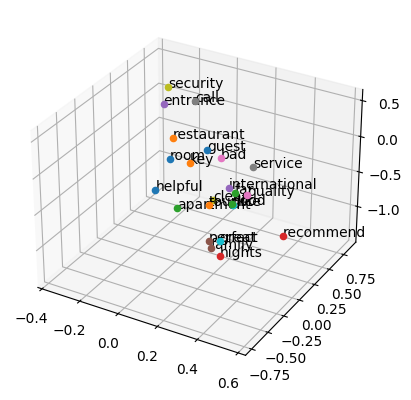

In [119]:
pca = PCA(n_components=3)
embeddings_reduced = pca.fit_transform(weights)


interesting_words = ['room', 'key', 'good', 'nights', 'international', 'perfect', 'quality', 'service', 'clean', 'great', 'guest', 'tourist', 'apartment', 'recommend', 'entrance', 'family', 'bad', 'call', 'security', 'nice', 'helpful', 'restaurant', 'far']
interesting_indices = [best_vectorize_layer.get_vocabulary().index(word) for word in interesting_words]
interesting_embeddings = embeddings_reduced[interesting_indices]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, word in enumerate(interesting_words):
    ax.scatter(interesting_embeddings[i, 0], interesting_embeddings[i, 1], interesting_embeddings[i, 2])
    ax.text(interesting_embeddings[i, 0], interesting_embeddings[i, 1], interesting_embeddings[i, 2], word)
plt.show()

### Kmeans embeddings:

In [121]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(weights)
cluster_labels = kmeans.labels_

# Print the words in each cluster
for i in range(num_clusters):
    cluster = np.where(cluster_labels == i)[0][:15]
    words = ([best_inverse_vocab[c] for c in cluster])
    print(f"Cluster {i}: {words}")
    print('')

Cluster 0: ['la', 'situation', 'con', 'de', 'en', 'un', 'standing', 'correct', 'el', 'ben', 'bon', 'bien', 'trs', 'du', 'confortable']

Cluster 1: ['', 'stopword', 'rareword', 'around', 'coffee', 'tube', 'buffet', 'luggage', 'table', 'fruit', 'store', 'daily', 'wireless', 'eggs', 'machine']

Cluster 2: ['hotel', 'room', 'good', 'staff', 'would', 'location', 'rooms', 'nice', 'clean', 'quot', 'breakfast', 'service', 'get', 'small', 'place']

Cluster 3: ['[UNK]', 'great', 'stay', 'one', 'stayed', 'us', 'night', 'time', 'also', 'day', 'back', 'floor', 'london', 'two', 'walk']

